# Random Forest Classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.



In [13]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


df = pd.read_csv("data.csv")

In [2]:
#Eliminate " Unnamed: 32" & "id"
df= df.drop("Unnamed: 32",axis=1)
df= df.drop("id", axis=1)
df= df.replace({"M":1, "B":0})

#Drop less important features
drop_col = ["fractal_dimension_se", "smoothness_se", "fractal_dimension_mean", "texture_se", "symmetry_se"]

df=df.drop(drop_col, axis=1)

# New model - Removing features

In this model it will be eliminated the 10 less important features.

In [3]:
to_drop = ['fractal_dimension_worst',
            'concavity_se',
            'perimeter_se',
            'area_se',
            'smoothness_mean',
            'compactness_se',
            'concave points_se',
            'symmetry_mean',
            'radius_se',
            'compactness_mean'] 

new_df = df.drop(to_drop, axis=1)
new_df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,concavity_mean,concave points_mean,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst
0,1,17.99,10.38,122.80,1001.0,0.30010,0.14710,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601
1,1,20.57,17.77,132.90,1326.0,0.08690,0.07017,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750
2,1,19.69,21.25,130.00,1203.0,0.19740,0.12790,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613
3,1,11.42,20.38,77.58,386.1,0.24140,0.10520,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638
4,1,20.29,14.34,135.10,1297.0,0.19800,0.10430,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.24390,0.13890,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060
565,1,20.13,28.25,131.20,1261.0,0.14400,0.09791,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572
566,1,16.60,28.08,108.30,858.1,0.09251,0.05302,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218
567,1,20.60,29.33,140.10,1265.0,0.35140,0.15200,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087


In [4]:
#Creating my predictive variable (X) and my target variable (Y)

#y = Target Variable
y = df.iloc[:,0]

#X= Predictors
X= new_df.iloc[:,1:]


### Randomised Search CV

We can use scikit learn and RandomisedSearchCV where we can define the grid, the random forest model will be fitted over and over by randomly selecting parameters from the grid. 

In [7]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [5]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

NameError: name 'RandomizedSearchCV' is not defined

In [6]:
# The best parameters from fitting the random search
rf_random.best_params_

NameError: name 'rf_random' is not defined

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [8]:
#Tuned model
tuned_model = RandomForestClassifier(n_estimators= 1600, 
                                min_samples_split= 5,
                                min_samples_leaf= 2,
                                max_features= 'sqrt',
                                max_depth= 10,
                                bootstrap= False,
                                random_state=99)


## K-fold cross-validation

In [9]:
#5-fold cross-validation in training data
scores = cross_val_score(tuned_model, X_train, y_train, scoring='accuracy', cv=10)  
print("Accuracy mean:" ,scores.mean())
print("STD:" ,scores.std())

Accuracy mean: 0.9555370985603544
STD: 0.04093039585428107


### Evaluate Cross-Validation Results:

In [10]:
print("Accuracy mean:" ,scores.mean())
print("STD:" ,scores.std())

Accuracy mean: 0.9555370985603544
STD: 0.04093039585428107


Overall, a mean accuracy of 0.9554 suggests that the model is performing well, with an average accuracy of about 95.54%. 

The small standard deviation (0.0188) implies that the model's performance did not vary significantly between the different cross-validation folds, indicating a stable and consistent model. 

However, it's essential to keep in mind that these results are based on the training data, and you should still evaluate your model's performance on a separate holdout test set to assess its generalization to new, unseen data.

The test set is exclusively reserved for the final evaluation of the model after cross-validation. Cross-validation is performed solely on the training dataset. This ensures that the test set remains 'invisible' to the model during the development and tuning phases, preventing any information leakage that could bias the evaluation of the model's performance.

# Final Model Evaluation

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        90
           1       0.98      0.98      0.98        53

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



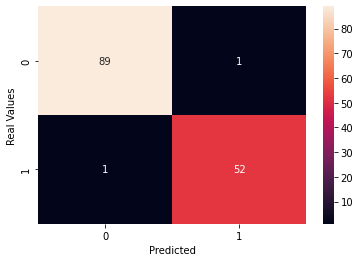

In [11]:
tuned_model.fit(X_train, y_train)

y_pred=tuned_model.predict(X_test)

confusion_matrix_tuned = pd.crosstab(y_test, y_pred, rownames=['Real Values'], colnames=['Predicted'])
sn.heatmap(confusion_matrix_tuned, annot=True)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

*Accuracy* = Simple measure of total error. The proportion of predictions that are correct. In this case 0.99.

*Sensitivity (recall)* = measures the strength of the model to predict a positive outcome - the proportion of the 1s that it correctly identifies. 

In this context, the instances labeled as '1s' carry greater significance, as misclassifying them as '0s' incurs a higher cost compared to misclassifying '0s' as '1s.' The rationale behind this assessment is that any occurrence of a False Positive could potentially lead to a subsequent interpretation as a benign breast tumor in further clinical studies. Conversely, a False Negative scenario, coupled with the absence of subsequent follow-up studies, can expose the patient to severe health risks.

In [15]:
# Metrics:

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

recall = recall_score(y_test, y_pred)
print(f'Sensibilidad (Recall): {recall}')

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

Accuracy: 0.986013986013986
Precision: 0.9811320754716981
Sensibilidad (Recall): 0.9811320754716981
F1 Score: 0.9811320754716981


These metrics indicate that your classification model exhibits outstanding performance in the task it is performing. 

Both precision and recall are exceptionally high, suggesting that the model is capable of correctly classifying the majority of positive instances while maintaining a low number of false positives. 

Accuracy is also high, signifying that the model correctly classifies the majority of instances overall. The F1 score, a measure that combines precision and recall, is also high in this case.

AUC=0.9850104821802935


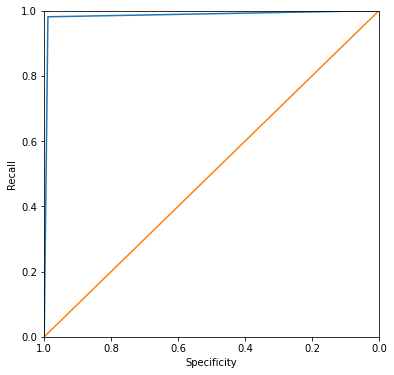

In [26]:
#ROC curve 

from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(np.array(y_test), y_pred)

roc_df =pd.DataFrame({'recall':tpr,  'specificity': 1 - fpr})
auc = metrics.roc_auc_score(np.array(y_test), y_pred)

ax = roc_df.plot(x='specificity', y='recall', figsize =(6,6), legend = False)
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0),(0,1))
ax.set_xlabel('Specificity')
ax.set_ylabel('Recall')


print("AUC="+str(auc))

*AUC:* indicates excellent performance for your classification model. 

The AUC measures the ability of the model to distinguish between positive and negative cases, with a value of 1.0 representing perfect discrimination and 0.5 representing random guessing. 

An AUC value close to 1 suggests that your model is doing an outstanding job in separating the classes, making it highly effective for its intended purpose.